In [ ]:
# Installing kaggle
!pip install -q kaggle

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/Kaggle_credentials/kaggle.json  ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.04G/1.04G [00:47<00:00, 25.5MB/s]
100% 1.04G/1.04G [00:47<00:00, 23.5MB/s]


In [ ]:
! unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

## Importing Modules


In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM , Embedding , Dropout,add

## Features extraction

In [ ]:
# Loading VGG16 model
model = VGG16()

# Restructuring the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Summarizing the model
print(model.summary())

553467096/553467096 [==============================] - 24s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
model.save('VGGModel.h5')

In [ ]:
# Extracting features from images
features = {}
directory = os.path.join('/content/Images')

for img_name in tqdm(os.listdir(directory)):
  img_path = directory + '/' + img_name
  image = load_img(img_path, target_size=(224,224))

  # Img to np array
  image = img_to_array(image)

  # Reshaping
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

  # Preprocessing for passing through VGG16
  image = preprocess_input(image)

  feature = model.predict(image, verbose=0)

  # Getting image id
  image_id = img_name.split('.')[0]

  # Storing features
  features[image_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# Storing features
pickle.dump(features, open(os.path.join('/content/drive/MyDrive/Features', 'features.pkl'), 'wb'))

In [ ]:
# Loading features from file ( which is created in above step)
with open(os.path.join('/content/drive/MyDrive/Features', 'features.pkl'), 'rb') as f:
  features = pickle.load(f)

## Loading Captions

In [ ]:
with open(os.path.join('/content/captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()

In [ ]:
# Mapping image with captions
mapping = {}

# Process lines
for line in tqdm(captions_doc.split('\n')) :
  # spliting line by comma
  tokens = line.split(',')
  if len(line) < 2 :
    continue
  image_id, caption = tokens[0], tokens[1:]

  # Extracting image id from image name
  image_id = image_id.split('.')[0]

  # Caption list to string
  caption = " ".join(caption)

  if image_id not in mapping :
    mapping[image_id] = []
  mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

## Text preprocessing

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# Before preprocessing text
mapping['1015118661_980735411b']

['A boy smiles in front of a stony wall in a city .',
 'A little boy is standing on the street while a man in overalls is working on a stone wall .',
 'A young boy runs aross the street .',
 'A young child is walking on a stone paved street with a metal pole and a man behind him .',
 'Smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him .']

In [ ]:
clean(mapping)

In [ ]:
# After preprocessing text
mapping['1015118661_980735411b']

['startseq boy smiles in front of stony wall in city endseq',
 'startseq little boy is standing on the street while man in overalls is working on stone wall endseq',
 'startseq young boy runs aross the street endseq',
 'startseq young child is walking on stone paved street with metal pole and man behind him endseq',
 'startseq smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him endseq']

In [ ]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [ ]:
# Tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
vocab_size

8485

In [ ]:
# Getting max length of caption
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

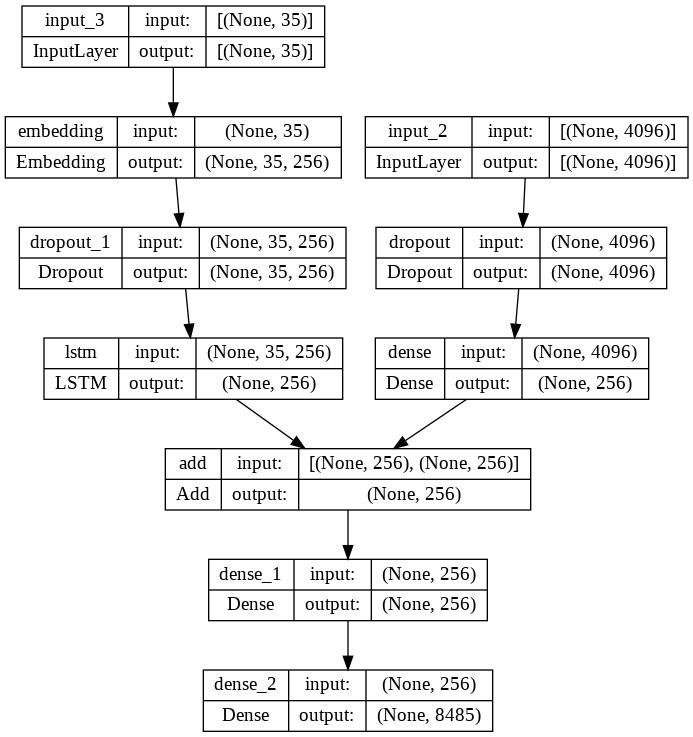

In [ ]:
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 30
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 55s 242ms/step - loss: 1.9758


In [ ]:
# Saving the model
model.save('CapGen.h5')

## Generating Captions


In [ ]:
# loading models
VGGmodel = tf.keras.models.load_model('models/VGGModel.h5')
Cap_model = tf.keras.models.load_model('models/CapGen.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.542342
BLEU-2: 0.314581


In [ ]:
# Feature extractor
def feature_extractor(img_path):
  image = load_img(img_path, target_size=(224,224))

    # Img to np array
  image = img_to_array(image)

  # Reshaping
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

  # Preprocessing for passing through VGG16
  image = preprocess_input(image)

  feature = VGGmodel.predict(image, verbose=0)
  
  return feature

In [ ]:
# Visualizing Results
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image = Image.open(image_name)
    # predict the caption
    y_pred = predict_caption(Cap_model, feature_extractor(image_name), tokenizer, max_length)
    print('--------------------Predicted--------------------')
    y_pred = y_pred[8:-7].upper()
    print(y_pred)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
 TWO DOGS ARE PLAYING WITH EACH OTHER ON THE BEACH


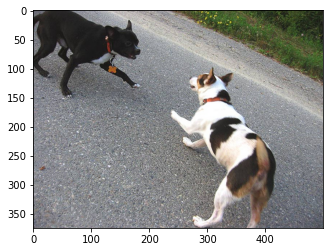

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq man doing back flip while another takes picture endseq
startseq person is taking picture of another person doing flip in midair in the grass endseq
startseq young man takes picture of his friend doing gymnastics in field endseq
startseq one man taking photo of another man jumping in field by small tree endseq
startseq one person does flip in the middle of the field while their friend takes picture endseq
--------------------Predicted--------------------
 MAN IS RIDING HIS BIKE ACROSS FIELD


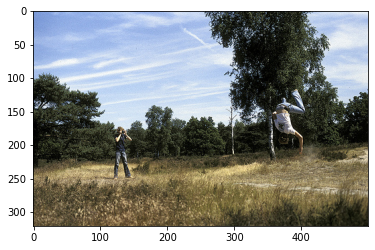

In [ ]:
generate_caption("207237775_fa0a15c6fe.jpg")

---------------------Actual---------------------
startseq man looks through his binoculars while another man holds drink endseq
startseq man with thermos is standing next to man who is gazing through binoculars endseq
startseq two men are standing together while one looks through binoculars endseq
startseq two men look out as one is holding binoculars endseq
startseq two people standing next to each other with mountains in the distance endseq
--------------------Predicted--------------------
 WOMAN IS STANDING ON UNIQUE SMOKING


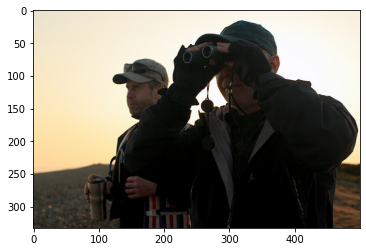

In [ ]:
generate_caption("2096771662_984441d20d.jpg")

---------------------Actual---------------------
startseq male hiker wearing green jacket is posing next to large glacier endseq
startseq man with camera and an ice structure behind him endseq
startseq man with camera crouching on ice endseq
startseq man with camera kneels in front of giant hill of snow endseq
startseq the mountain climber prepares to take photo endseq
--------------------Predicted--------------------
 MAN IN YELLOW JACKET AND BACKPACK IS WALKING ON THIN RUNWAY


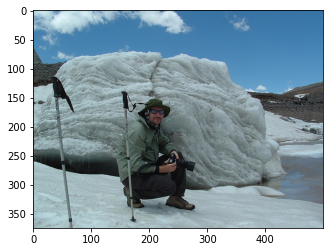

In [ ]:
generate_caption("2097420505_439f63c863.jpg")

---------------------Actual---------------------
startseq brown chow mix dog is standing in front of van with euro plats in the middle of messy yard endseq
startseq brown dog standing in muddy yard endseq
startseq brown dogs walks near green van and some junk endseq
startseq large brown dog stands in front of green van in the yard of house endseq
startseq yellow dog is standing in front of green car and next to toilet endseq
--------------------Predicted--------------------
 TWO DOGS PLAY IN THE YARD


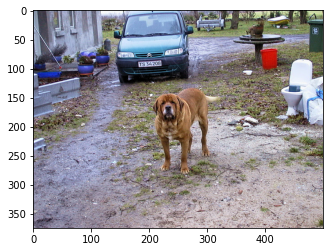

In [ ]:
generate_caption("2098418613_85a0c9afea.jpg")

---------------------Actual---------------------
startseq dog in the snow endseq
startseq dog laying in the snow endseq
startseq dog lays on the snow endseq
startseq golden dog plays in the snow endseq
startseq red dog crouches in the snow endseq
--------------------Predicted--------------------
 TWO DOGS PLAY IN THE SNOW


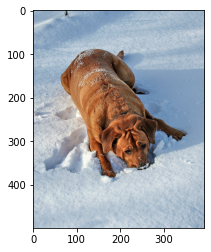

In [ ]:
generate_caption("2085400856_ae09df33a7.jpg")

---------------------Actual---------------------
startseq man casting fishing pole endseq
startseq man casting out fishing line into stream endseq
startseq man fishes endseq
startseq man standing on edge of stream while casting his fishing line endseq
startseq someone casts fishing line into body of water endseq
--------------------Predicted--------------------
 MAN CASTING FISHING LINE INTO THE WATER


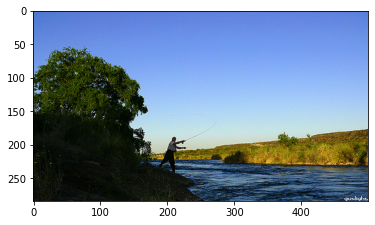

In [ ]:
generate_caption("2076865206_53918c820c.jpg")

---------------------Actual---------------------
startseq hiker posing for photo in an arid mountain landscape endseq
startseq man in green hat poses in the mountains endseq
startseq man in green hat standing on slope in front of mountain endseq
startseq "a man in camouflage hiking gear wearing green pouch is standing in the foothills ." endseq
startseq person in hiking gear is standing on hill with mountain in the background endseq
--------------------Predicted--------------------
 HIKER IS RIDING ON BIKE


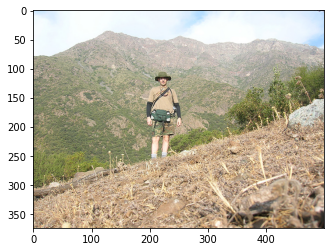

In [ ]:
generate_caption("2067833088_04e84e5bf2.jpg")

---------------------Actual---------------------
startseq boy pushing another boy up pole endseq
startseq little boy pushing another little boy up the pole endseq
startseq one boy is helping another boy to climb green pole in the street endseq
startseq one small boy climbing pole with the help of another boy on the ground endseq
startseq the boy is trying to push another up pole endseq
--------------------Predicted--------------------
 MAN IN RED SHIRT AND RED PANTS IS CLIMBING ON POLE


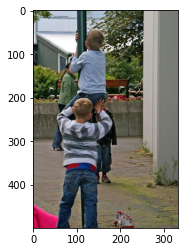

In [ ]:
generate_caption("1342766791_1e72f92455.jpg")

---------------------Actual---------------------
startseq the two children make funny pose in front of some bushes endseq
startseq two boys in blue shirts are doing funny poses endseq
startseq two boys in blue shirts wearing backpacks endseq
startseq two boys posing in blue shirts and khaki shorts endseq
startseq two boys wearing matching blue polo shirts strike goofy pose endseq
--------------------Predicted--------------------
 TWO BOYS ARE PLAYING GOLF ON LEASHES


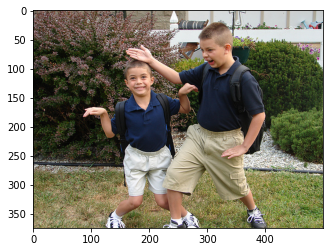

In [ ]:
generate_caption("1335617803_4fbc03dab0.jpg")

---------------------Actual---------------------
startseq brown dog on leash runs through the white water endseq
startseq soaked dog is playing in the water endseq
startseq tan dog on leash running in shallow ocean water endseq
startseq wet dog on leash is running through some water endseq
startseq brown dog running through shallow water endseq
--------------------Predicted--------------------
 TAN DOG IS RUNNING THROUGH THE WATER


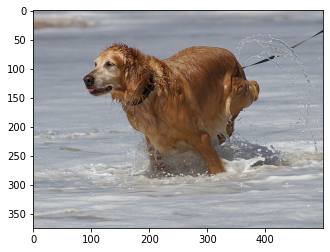

In [ ]:
generate_caption("1348891916_ebd4413033.jpg")

---------------------Actual---------------------
startseq man in field backed by american flags endseq
startseq man is being thrown frisbee in front of monument and flags endseq
startseq man is clapping at the base of the washington memorial endseq
startseq man stands in front of the gateway arch endseq
startseq man tries to catch football on grass surrounded by american flags endseq
--------------------Predicted--------------------
 MAN IN BLACK JACKET AND BACKPACK STANDS ON THE GRASS


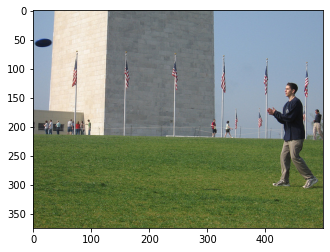

In [ ]:
generate_caption("135235570_5698072cd4.jpg")